# Data Analysis
Analyze the dataset (identification.tar) provided to you and the images associated embeddings, and report TWO significant findings you believe will impact the model or system's performance.

#### Import necessary libraries

In [1]:
# Import all libraries necessary for analysis
import sys
sys.path.insert(1,'../')
from src.search.search import Measure
from pipeline import Pipeline, MULTI_IMAGE_GALLERY_STORAGE
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

#### Precompute all embeddings for all models

In [19]:
# Precompute all embeddings for all 4 models
pipeline_064_018 = Pipeline(image_size=64, architecture='resnet_018',
                        dimension=256, measure=Measure.euclidean, gallery_folder=MULTI_IMAGE_GALLERY_STORAGE)
pipeline_064_034 = Pipeline(image_size=64, architecture='resnet_034',
                        dimension=256, measure=Measure.euclidean, gallery_folder=MULTI_IMAGE_GALLERY_STORAGE)
pipeline_224_018 = Pipeline(image_size=224, architecture='resnet_018',
                        dimension=256, measure=Measure.euclidean, gallery_folder=MULTI_IMAGE_GALLERY_STORAGE)
pipeline_224_034 = Pipeline(image_size=224, architecture='resnet_034',
                        dimension=256, measure=Measure.euclidean, gallery_folder=MULTI_IMAGE_GALLERY_STORAGE)

Calculating embeddings...
Indexing embeddings...
Calculating embeddings...
Indexing embeddings...
Calculating embeddings...
Indexing embeddings...
Calculating embeddings...
Indexing embeddings...


#### Calculate principal components of all embeddings for all 4 models

In [2]:
model_embeddings = {}
model_pca = {}
for image_size in [64, 224]:
    for arch in ['resnet_018', 'resnet_034']:
        model = f'model_size_{image_size:03}_{arch}'
        pattern = f'../storage/embeddings/{model}/*/*.npy'
        npy_files = glob(pattern)
        embeddings = np.zeros([len(npy_files), 256])
        for i in range(len(npy_files)):
            filename = npy_files[i]
            with open(filename, 'rb') as f:
                embeddings[i,:] = np.load(f).T

        X_reduced = PCA(n_components=2).fit_transform(embeddings)
        model_pca[model] = X_reduced
        model_embeddings[model] = embeddings
# Get names of the person in each image
names = [filename.split('/')[-2] for filename in npy_files]

## 1. Model Differences

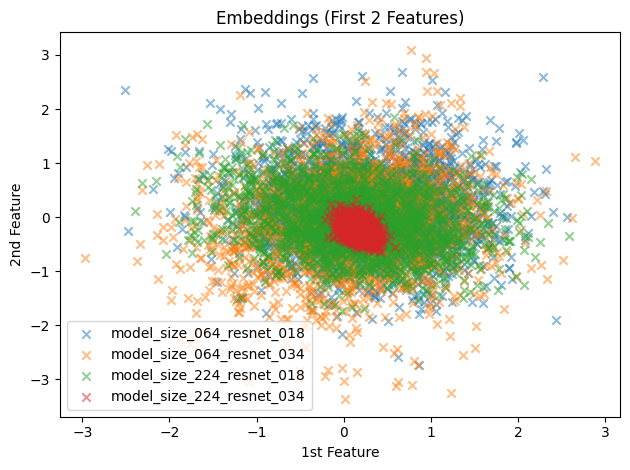

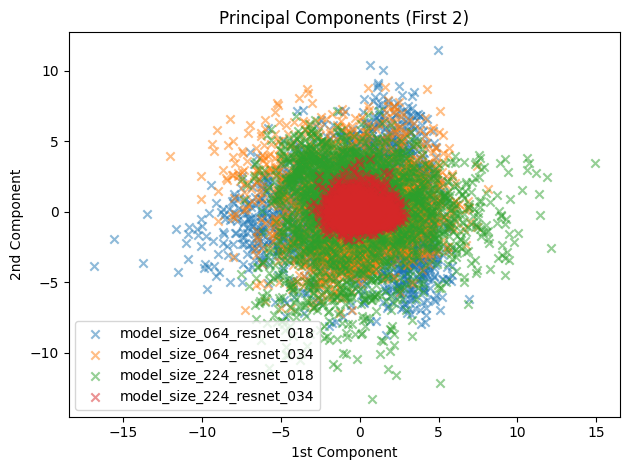

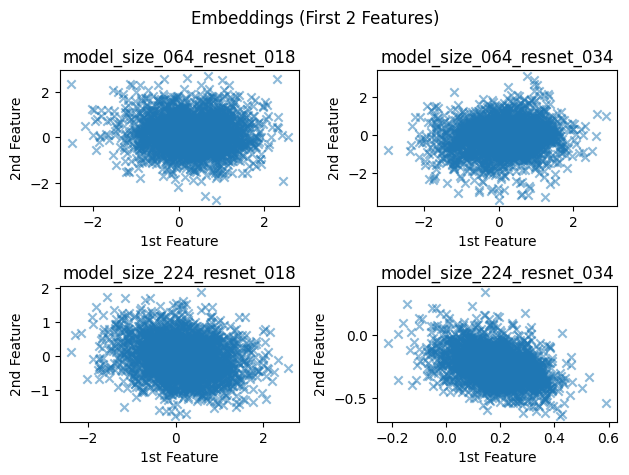

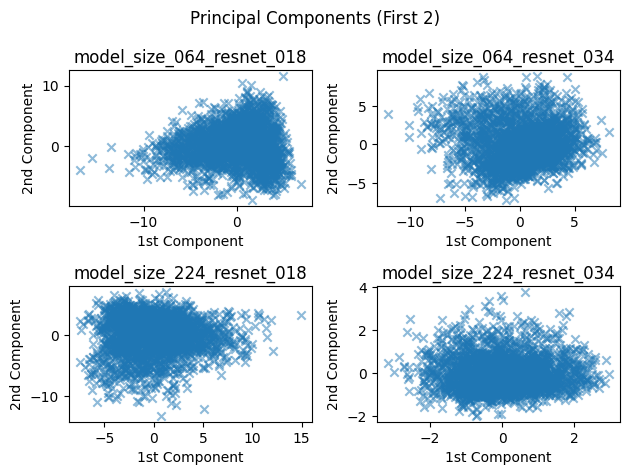

In [138]:
# Initialize plot axes
fig1, ax1 = plt.subplots() # Embeddings
fig2, ax2 = plt.subplots() # PCA
fig3, ax3 = plt.subplots(2,2) # Embeddings (subplots)
fig4, ax4 = plt.subplots(2,2) # PCA (subplots)

# Plot data
models = list(model_embeddings.keys())
for i in range(len(models)):
    m = models[i]
    ax1.scatter(model_embeddings[m][:,0], model_embeddings[m][:,1], label=m, marker='x', alpha=0.5)
    ax2.scatter(model_pca[m][:,0], model_pca[m][:,1], label=m, marker='x', alpha=0.5)
    embAx = ax3[i//2,i%2]
    pcaAx = ax4[i//2,i%2]
    embAx.scatter(model_embeddings[m][:,0], model_embeddings[m][:,1], label=m, marker='x', alpha=0.5)
    embAx.set_title(m)
    embAx.set_xlabel('1st Feature')
    embAx.set_ylabel('2nd Feature')
    pcaAx.scatter(model_pca[m][:,0], model_pca[m][:,1], label=m, marker='x', alpha=0.5)
    pcaAx.set_title(m)
    pcaAx.set_xlabel('1st Component')
    pcaAx.set_ylabel('2nd Component')

# Format plots
ax1.legend()
ax1.set_title('Embeddings (First 2 Features)')
ax1.set_xlabel('1st Feature')
ax1.set_ylabel('2nd Feature')
fig1.tight_layout()

ax2.legend()
ax2.set_title('Principal Components (First 2)')
ax2.set_xlabel('1st Component')
ax2.set_ylabel('2nd Component')
fig2.tight_layout()

fig3.suptitle('Embeddings (First 2 Features)')
fig3.tight_layout()

fig4.suptitle('Principal Components (First 2)')
fig4.tight_layout()

plt.show()


# 2. Cluster Differences

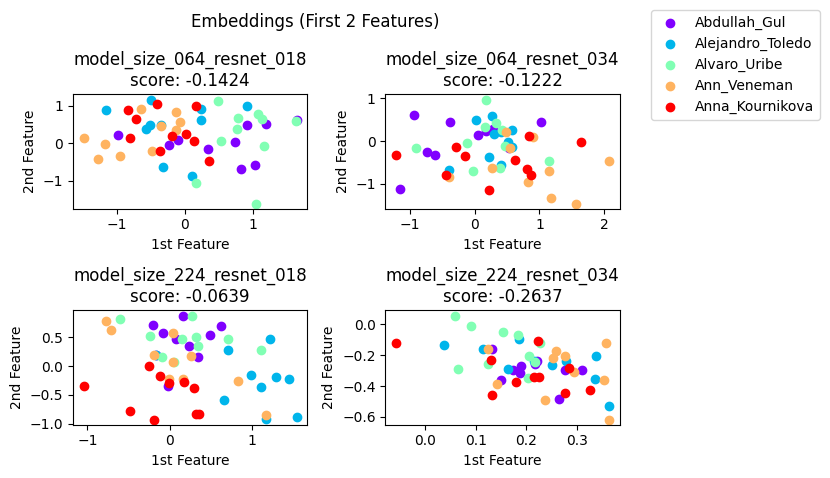

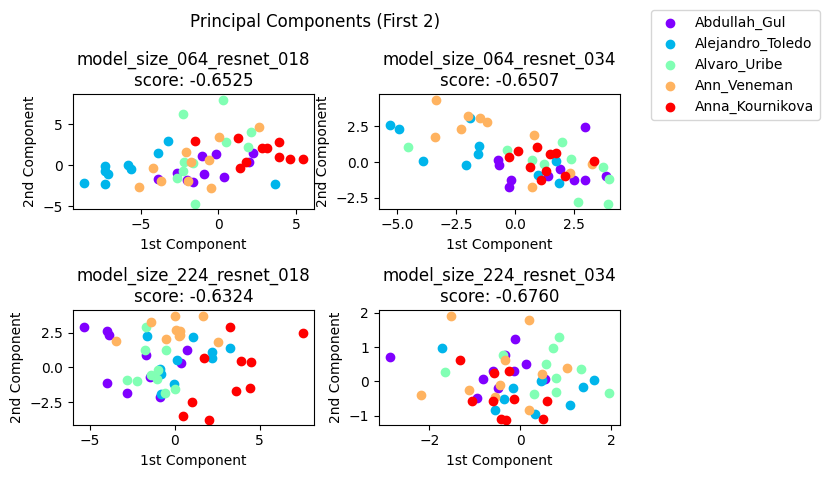

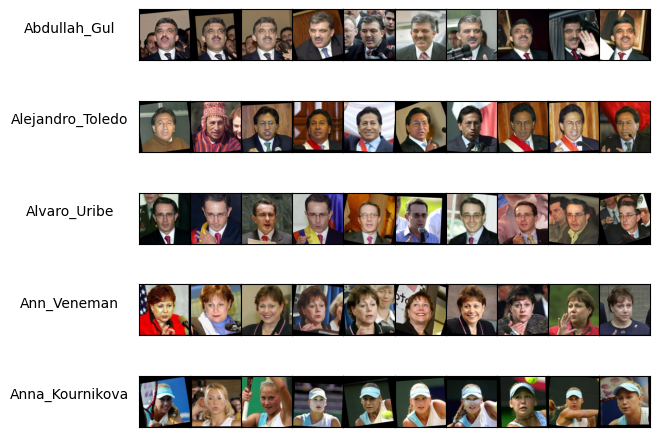

In [160]:
# Watch office hours recording
# optimal k starts near sqrt(N)
# print(np.sqrt(model_embeddings[model].shape[0])) 

from collections import Counter
from sklearn.metrics import silhouette_score
from PIL import Image
import matplotlib.cm as cm

# Determine number of people to plot (multiple images per person)
nPeople = 5

# Encode name labels
enc = LabelEncoder()
encoded_labels = enc.fit_transform(names)

# Find top nPeople with the most images
name_counts = Counter(names)
# name_counts = {x: count for x, count in name_counts.items() if count <= 3}
sorted_names = sorted(name_counts.keys(), key=lambda x: (-name_counts[x],x))
topPeople = sorted_names[:nPeople]
topPeopleMask = [n in topPeople for n in names]

# Get the encoded labels for the top nPeople
topPeopleLabels = encoded_labels[topPeopleMask]

# Initialize colors list
colors = cm.rainbow(np.linspace(0, 1, len(topPeople)))

# Initialize plot axes
fig1, ax1 = plt.subplots(2,2) # Embeddings
fig2, ax2 = plt.subplots(2,2) # PCA

# Plot embeddings and pca figures for all 4 models, color-coded by person
models = list(model_embeddings.keys())
for i in range(len(models)):
    m = models[i]
    emb = model_embeddings[m][topPeopleMask,:]
    pca = model_pca[m][topPeopleMask,:]
    # Calculate overall silhouette score for the model (embeddings and pca)
    emb_silhouette = silhouette_score(model_embeddings[m], encoded_labels)
    pca_silhouette = silhouette_score(model_pca[m], encoded_labels)
    # Get axes
    embAx = ax1[i//2,i%2]
    pcaAx = ax2[i//2,i%2]
    # Plot points for each person in a different color
    for j in range(len(topPeople)):
        person = topPeople[j]
        personMask = topPeopleLabels == enc.transform([person])
        embAx.scatter(emb[personMask,0],emb[personMask,1],c=colors[j],label=person)
        pcaAx.scatter(pca[personMask,0],pca[personMask,1],c=colors[j],label=person)
    # Add titles and axis labels to subplots
    embAx.set_title(f'{m}\nscore: {emb_silhouette:.4f}')
    embAx.set_xlabel('1st Feature')
    embAx.set_ylabel('2nd Feature')
    pcaAx.set_title(f'{m}\nscore: {pca_silhouette:.4f}')
    pcaAx.set_xlabel('1st Component')
    pcaAx.set_ylabel('2nd Component')

# Format plots
fig1.suptitle('Embeddings (First 2 Features)')
line, label = embAx.get_legend_handles_labels()
fig1.legend(line, label,bbox_to_anchor=(1.3, 1))
fig1.tight_layout()

fig2.suptitle('Principal Components (First 2)')
line2, label2 = pcaAx.get_legend_handles_labels()
fig2.legend(line2, label2,bbox_to_anchor=(1.3, 1))
fig2.tight_layout()

plt.show()

# Display the images of the top nPeople
fig, ax = plt.subplots(nPeople,10)
for i in range(nPeople):
    pattern = f'../{MULTI_IMAGE_GALLERY_STORAGE}/{topPeople[i]}/*.jpg'
    jpg_files = glob(pattern)
    for j in range(len(jpg_files)):
        probe = Image.open(jpg_files[j])
        axs = ax[i,j]
        axs.imshow(probe)
        axs.set_xticks([])
        axs.set_yticks([])
        if j==0:
            axs.set_ylabel(topPeople[i], rotation=0, labelpad=50)
fig.tight_layout(pad=0.0)
plt.show()